In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from pure_ldp.frequency_oracles.direct_encoding import DEClient


In [10]:
# Cargar datos
data_path = '../data/raw/bank-full.csv'
df = pd.read_csv(data_path, sep=';')
df['y'] = df['y'].map({'no': 0, 'yes': 1})
X = df.drop(columns=['y'])
y = df['y']

# Mejores parámetros encontrados
best_params_rf = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [11]:
# Crear carpetas para guardar las figuras y resultados
figures_base = 'figures'
results_base = 'results'
os.makedirs(figures_base, exist_ok=True)
os.makedirs(results_base, exist_ok=True)
method = 'Direct_Encoding'
method_path = os.path.join(figures_base, method)
os.makedirs(method_path, exist_ok=True)
subfolders = ['Original'] + [f'eps_{eps}' for eps in [5, 1, 0.5, 0.1]]
for subfolder in subfolders:
    os.makedirs(os.path.join(method_path, subfolder), exist_ok=True)


In [ ]:
# Función para mapear variables categóricas binarias y meses
def map_binary_columns(df):
    df['default'] = df['default'].map({'no': 0, 'yes': 1})
    df['housing'] = df['housing'].map({'no': 0, 'yes': 1})
    df['loan'] = df['loan'].map({'no': 0, 'yes': 1})
    df['month'] = df['month'].map({
        'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
        'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
        'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
    })
    return df

# Función para convertir variables numéricas en categóricas
def convert_numerics_to_categories(df):
    bins_age = [18, 30, 40, 50, 60, 95]
    labels_age = ['18-30', '31-40', '41-50', '51-60', '61+']
    df['age'] = pd.cut(df['age'], bins=bins_age, labels=labels_age, include_lowest=True)

    bins_balance = [-8019, 0, 72, 448, 1428, 102127]
    labels_balance = ['negative', '0-72', '73-448', '449-1428', '1429+']
    df['balance'] = pd.cut(df['balance'], bins=bins_balance, labels=labels_balance, include_lowest=True)

    bins_day = [1, 7, 14, 21, 31]
    labels_day = ['1-7', '8-14', '15-21', '22-31']
    df['day'] = pd.cut(df['day'], bins=bins_day, labels=labels_day, include_lowest=True)

    bins_duration = [0, 103, 180, 319, 4918]
    labels_duration = ['0-103', '104-180', '181-319', '320+']
    df['duration'] = pd.cut(df['duration'], bins=bins_duration, labels=labels_duration, include_lowest=True)

    bins_campaign = [1, 2, 3, 10, 63]
    labels_campaign = ['1', '2-3', '4-10', '11+']
    df['campaign'] = pd.cut(df['campaign'], bins=bins_campaign, labels=labels_campaign, include_lowest=True)

    bins_pdays = [-1, 0, 30, 90, 871]
    labels_pdays = ['no_contact', '0-30', '31-90', '91+']
    df['pdays'] = pd.cut(df['pdays'], bins=bins_pdays, labels=labels_pdays, include_lowest=True)

    bins_previous = [0, 1, 2, 5, 275]
    labels_previous = ['0', '1-2', '3-5', '6+']
    df['previous'] = pd.cut(df['previous'], bins=bins_previous, labels=labels_previous, include_lowest=True)

    return df

# Función para mapear variables categóricas a valores numéricos
def map_categorical_columns(df, categorical_columns):
    mappings = {}
    for col in categorical_columns:
        df[col] = df[col].astype(str).replace('nan', pd.NA)
        unique_values = sorted(df[col].dropna().unique())
        # Map to indices {1, ..., d} instead of {0, ..., d-1}
        mappings[col] = {value: idx + 1 for idx, value in enumerate(unique_values)}
        df[col] = df[col].map(mappings[col])
    return df, mappings

def apply_de(df, epsilon, categorical_columns, cat_mappings):
    df_de = df.copy()
    for col in categorical_columns:
        d = len(cat_mappings[col])
        de = DEClient(epsilon=epsilon, d=d)
        df_de[col] = df_de[col].apply(lambda x: de.privatise(x) if pd.notna(x) else x)
    return df_de

# Función para generar matrices de conteo (heatmaps) de feature vs target
def plot_feature_target_count_matrices(X_privatized, y, categorical_columns, cat_mappings, method, model_name):
    df_privatized = X_privatized.copy()
    df_privatized['y'] = y.reset_index(drop=True)

    for col in categorical_columns:
        if df_privatized[col].isna().all():
            print(f"Skipping {col}: all values are NaN")
            continue

        # Define reverse mapping based on whether data is privatized
        if method == 'Direct_Encoding' and model_name != 'Original':
            # Privatized data: map output index j (in {0, ..., d-1}) to category for input index j+1
            reverse_mapping = {idx - 1: cat for cat, idx in cat_mappings[col].items()}
        else:
            # Original data: map input index i (in {1, ..., d}) directly to category
            reverse_mapping = {idx: cat for cat, idx in cat_mappings[col].items()}
        
        # Ensure integer type and handle NaN
        df_privatized[col] = df_privatized[col].apply(lambda x: int(x) if pd.notna(x) else x)
        df_privatized[col] = df_privatized[col].map(reverse_mapping, na_action='ignore')

        if df_privatized[col].isna().any():
            print(f"Warning: NaN values found in {col} after mapping. Filling with 'Unknown'")
            df_privatized[col] = df_privatized[col].fillna('Unknown')

        count_matrix = pd.crosstab(df_privatized['y'], df_privatized[col])
        if count_matrix.empty:
            print(f"Skipping {col}: count matrix is empty")
            continue

        categories = list(cat_mappings[col].keys())
        if 'Unknown' in df_privatized[col].values:
            categories = categories + ['Unknown']
        count_matrix = count_matrix.reindex(columns=categories, fill_value=0)
        
        if len(count_matrix) == 1:
            if 0 in count_matrix.index:
                count_matrix.loc[1] = 0
            else:
                count_matrix.loc[0] = 0
            count_matrix = count_matrix.sort_index()
        count_matrix.index = ['y=0', 'y=1']

        plt.figure(figsize=(max(6, len(categories) * 0.5), 3))
        sns.heatmap(count_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
        plt.title(f'Count Matrix: {col} vs Target ({method}, {model_name})')
        plt.xlabel(f'{col} Categories')
        plt.ylabel('Target (y)')
        plt.tight_layout()
        filepath = os.path.join('figures', method, model_name, f'count_matrix_{col}.png')
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        plt.close()
        
# Procesamiento completo
def process_data(X, y, categorical_columns, cat_mappings, apply_DE=False, epsilon=None):
    x = X.copy()
    if apply_DE and epsilon:
        x = apply_de(x, epsilon, categorical_columns, cat_mappings)

    x = pd.get_dummies(x, columns=categorical_columns, drop_first=True, dtype='int64')
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

    smoteenn = SMOTEENN(random_state=42)
    X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)
    print(f"After SMOTEENN: X_train_resampled shape = {X_train_resampled.shape}, y_train_resampled shape = {y_train_resampled.shape}")

    rf = RandomForestClassifier(**best_params_rf, random_state=42)
    boruta = BorutaPy(rf, n_estimators='auto', perc=95, verbose=0, random_state=42)
    boruta.fit(X_train_resampled.values, y_train_resampled.values.ravel())
    selected_features = X_train_resampled.columns[boruta.support_].tolist()
    print(f"Boruta selected {len(selected_features)} features: {selected_features}")

    return X_train_resampled[selected_features], X_test[selected_features], y_train_resampled, y_test

# Entrenar y evaluar modelo
def evaluate_model(X_train, y_train, X_test, y_test):
    print(f"Training model with X_train shape = {X_train.shape}, y_train shape = {y_train.shape}")
    model = RandomForestClassifier(**best_params_rf, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    conf_matrix = confusion_matrix(y_test, y_pred)
    actual_negatives, actual_positives = conf_matrix[0].sum(), conf_matrix[1].sum()
    false_positive_pct = conf_matrix[0][1] / actual_negatives if actual_negatives > 0 else 0
    false_negative_pct = conf_matrix[1][0] / actual_positives if actual_positives > 0 else 0
    return {
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Type I Error': false_positive_pct,
        'Type II Error': false_negative_pct
    }

# Función para ejecutar iteraciones y recolectar resultados
def run_iterations(X, y, categorical_columns, cat_mappings, method='none', epsilon=None, n_iterations=10):
    results = []
    for i in range(n_iterations):
        print(f"Iteration {i+1}/{n_iterations} for method={method}, epsilon={epsilon}")
        # Procesar datos
        if method == 'de':
            X_iter = apply_de(X.copy(), epsilon, categorical_columns, cat_mappings)
        else:
            X_iter = X.copy()
            
        # Generar heatmaps solo en la primera iteración
        if i == 0:
            model_name = f'eps_{epsilon}' if method == 'de' else 'Original'
            print(f"Generating count matrices for {model_name}...")
            plot_feature_target_count_matrices(X_iter, y, categorical_columns, cat_mappings, 'Direct_Encoding', model_name)

        # Procesar y evaluar
        X_train, X_test, y_train, y_test = process_data(X_iter, y, categorical_columns, cat_mappings)
        metrics = evaluate_model(X_train, y_train, X_test, y_test)
        results.append(metrics)
    return results

# Función para calcular estadísticas (mean, min, max) de los resultados
def compute_statistics(results):
    results_df = pd.DataFrame(results)
    return {
        'mean': results_df.mean().to_dict(),
        'min': results_df.min().to_dict(),
        'max': results_df.max().to_dict()
    }

# Función para guardar resultados en CSV
def save_results_to_csv(stats_dict, method_name):
    data = {}
    for model, stats in stats_dict.items():
        data[f'{model} (mean)'] = stats['mean']
        data[f'{model} (min)'] = stats['min']
        data[f'{model} (max)'] = stats['max']
    df = pd.DataFrame(data).round(4)
    df.to_csv(f'results/{method_name}_final_results.csv')
    return df



In [13]:
# Todas las columnas son ahora categóricas
all_categorical_columns = ['default', 'housing', 'loan', 'job', 'marital', 'education', 'contact', 'poutcome',
                           'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Epsilons y resultados
epsilons = [5, 3, 2, 1, 0.5, 0.1]
results_de_stats = {}
n_iterations = 10


In [14]:
X = map_binary_columns(X)
X = convert_numerics_to_categories(X)
X, cat_mappings = map_categorical_columns(X, all_categorical_columns)


In [15]:
# Modelo sin privacidad (Original)
print("Running iterations for Original...")
results_original = run_iterations(
    X, y, all_categorical_columns, cat_mappings, method='none', epsilon=None, n_iterations=1
)
results_de_stats['Original'] = compute_statistics(results_original)


Running iterations for Original...
Iteration 1/1 for method=none, epsilon=None
Generating count matrices for Original...
After SMOTEENN: X_train_resampled shape = (43714, 48), y_train_resampled shape = (43714,)
Boruta selected 32 features: ['month', 'housing_2', 'loan_2', 'job_2', 'job_5', 'job_8', 'job_10', 'marital_2', 'marital_3', 'education_2', 'education_3', 'contact_3', 'poutcome_3', 'poutcome_4', 'age_2', 'age_3', 'age_4', 'age_5', 'balance_2', 'balance_3', 'balance_4', 'balance_5', 'day_2', 'day_3', 'day_4', 'duration_2', 'duration_3', 'duration_4', 'campaign_3', 'campaign_4', 'pdays_3', 'pdays_4']
Training model with X_train shape = (43714, 32), y_train shape = (43714,)


In [16]:
# Modelos con Direct Encoding
for epsilon in epsilons:
    print(f"\nRunning iterations for Direct Encoding (ε={epsilon})...")
    results_de = run_iterations(
        X, y, all_categorical_columns, cat_mappings, method='de', epsilon=epsilon, n_iterations=n_iterations
    )
    results_de_stats[f'ε={epsilon}'] = compute_statistics(results_de)


Running iterations for Direct Encoding (ε=5)...
Iteration 1/10 for method=de, epsilon=5
Generating count matrices for eps_5...
After SMOTEENN: X_train_resampled shape = (43465, 48), y_train_resampled shape = (43465,)
Boruta selected 34 features: ['month', 'housing_1', 'loan_1', 'job_1', 'job_4', 'job_7', 'job_9', 'marital_1', 'marital_2', 'education_1', 'education_2', 'contact_1', 'contact_2', 'poutcome_2', 'poutcome_3', 'age_1', 'age_2', 'age_3', 'age_4', 'balance_1', 'balance_2', 'balance_3', 'balance_4', 'day_1', 'day_2', 'day_3', 'duration_1', 'duration_2', 'duration_3', 'campaign_1', 'campaign_2', 'campaign_3', 'pdays_2', 'pdays_3']
Training model with X_train shape = (43465, 34), y_train shape = (43465,)
Iteration 2/10 for method=de, epsilon=5
After SMOTEENN: X_train_resampled shape = (43369, 48), y_train_resampled shape = (43369,)
Boruta selected 33 features: ['month', 'housing_1', 'loan_1', 'job_1', 'job_4', 'job_7', 'job_9', 'marital_1', 'marital_2', 'education_1', 'education

In [17]:
# Guardar resultados en CSVs
print("Saving results to CSVs...")
results_de_df = save_results_to_csv(results_de_stats, 'Direct_Encoding')

Saving results to CSVs...


In [26]:
# Función para graficar con bigotes verticales (métricas en el eje X, modelos en la leyenda)
def plot_results_with_whiskers(stats_dict, title, colors):
    metrics = list(stats_dict['Original']['mean'].keys())
    models = list(stats_dict.keys())
    n_metrics = len(metrics)
    n_models = len(models)
    
    plt.figure(figsize=(11, 6))
    x_positions = np.arange(n_metrics) * 1.5  # Espaciado entre las métricas
    
    for model_idx, model in enumerate(models):
        means = []
        mins = []
        maxs = []
        for metric in metrics:
            means.append(stats_dict[model]['mean'][metric])
            mins.append(stats_dict[model]['min'][metric])
            maxs.append(stats_dict[model]['max'][metric])
        
        plt.scatter(x_positions + (model_idx - (n_models-1)/2) * 0.15, means, 
                    color=colors[model_idx], label=model, s=75) 
        for metric_idx in range(n_metrics):
            plt.vlines(x_positions[metric_idx] + (model_idx - (n_models-1)/2) * 0.15, 
                       mins[metric_idx], maxs[metric_idx], 
                       color=colors[model_idx], linestyle='-', linewidth=1)
    
    plt.xticks(x_positions, metrics, rotation=45, fontdict={'fontsize': 11})
    plt.yticks(fontsize=11)
    plt.title(title, fontdict={'fontsize': 16, 'weight': 'bold'})
    plt.xlabel('Metrics', fontdict={'fontsize': 13})
    plt.ylabel('Value', fontdict={'fontsize': 13})
    plt.legend(title='Models', bbox_to_anchor=(1, 1), loc='upper left', fontsize=11, title_fontsize=13)  
    plt.tight_layout()
    plt.show()


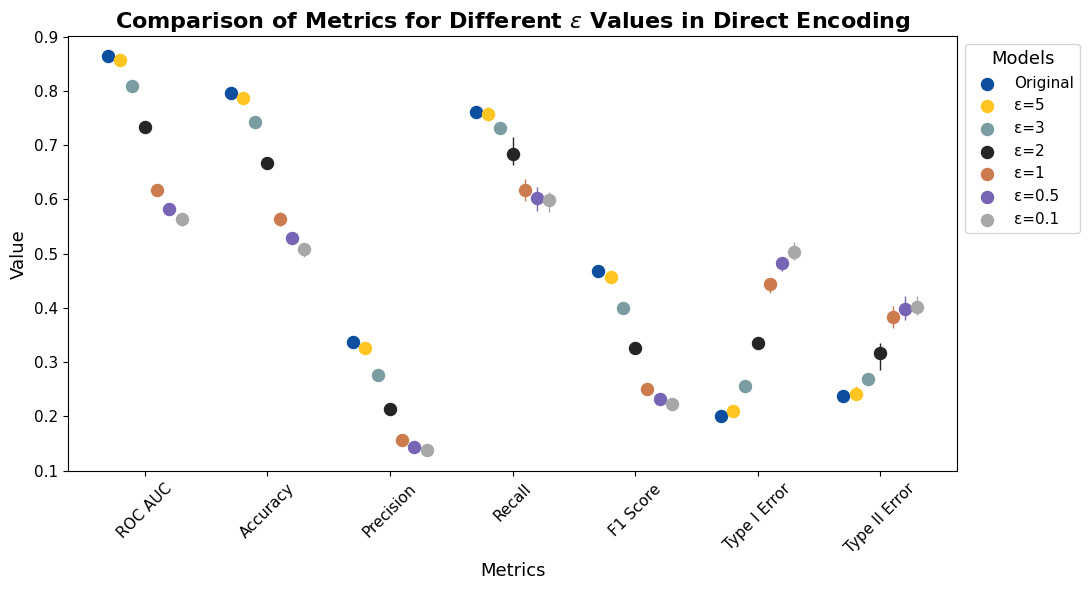

In [31]:
# Colores para los modelos (Original, ε=5, ε=1, ε=0.5, ε=0.1)
colors = ['#0d4e9e', '#ffc520', '#7b9ca0', '#242624', '#cc7b4f', '#7764B4', '#A6A8A8']

# Graficar resultados con bigotes verticales
plot_results_with_whiskers(results_de_stats, 'Comparison of Metrics for Different $\epsilon$ Values in Direct Encoding', colors)

In [32]:
# Función para graficar un radar chart
def plot_radar_chart(stats_dict, title, colors, filepath):
    # Métricas a incluir en el radar chart
    metrics = ['ROC AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
    models = list(stats_dict.keys())  # Niveles de privacidad (Original, ε=5, etc.)
    n_metrics = len(metrics)
    
    # Preparar los datos (usar las medias de cada métrica para cada modelo)
    data = []
    for model in models:
        values = [stats_dict[model]['mean'][metric] for metric in metrics]
        # Repetir el primer valor al final para cerrar el radar chart
        values += values[:1]
        data.append(values)
    
    # Calcular los ángulos para cada eje (métrica)
    angles = np.linspace(0, 2 * np.pi, n_metrics, endpoint=False).tolist()
    angles += angles[:1]  # Repetir el primer ángulo para cerrar el círculo
    
    # Crear el radar chart
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Graficar cada modelo (nivel de privacidad)
    for idx, (model_data, model) in enumerate(zip(data, models)):
        ax.fill(angles, model_data, color=colors[idx], alpha=0.25, label=model)
        ax.plot(angles, model_data, color=colors[idx], linewidth=2)
    
    # Configurar los ejes
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics, fontsize=12)
    
    # Añadir etiquetas de valores en los ejes (máximo y mínimo)
    ax.set_rlabel_position(30)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=10)
    plt.ylim(0, 1)
    
    # Añadir título y leyenda
    plt.title(title, size=15, color='black', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), fontsize=10)
    
    # Guardar la figura
    plt.tight_layout()
    plt.show()
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.close()

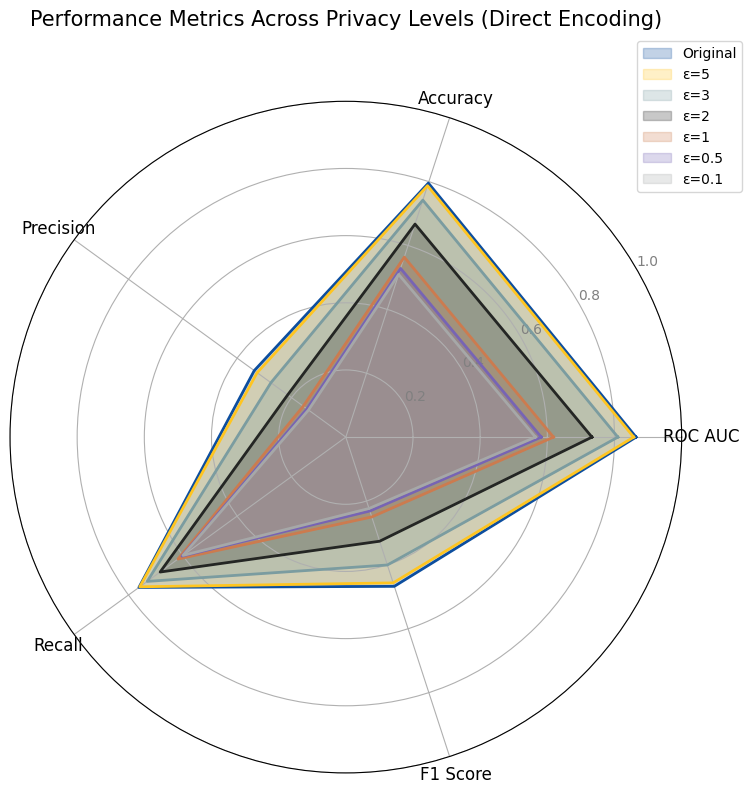

In [33]:
plot_radar_chart(
    results_de_stats,
    'Performance Metrics Across Privacy Levels (Direct Encoding)',
    colors,
    os.path.join('figures', 'Direct_Encoding', 'radar_chart.png')
)